## Making figure A6

Start by importing modules, data and defining functions

In [11]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt

from makeCorner import *

tmp_max = 100.
tmp_min = 2.

In [12]:
cdf_file = "../data/RUNS/power_law_only_high_sigmoids.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [13]:
def massModel_variation_all_m1(m1, alpha_ref, high_alpha, width_alpha, middle_alpha,
                               mu_m1, sig_m1, log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak,
                               mMax, high_mMax, width_mMax, middle_mMax,
                               mMin, high_mMin, width_mMin, middle_mMin,
                               dmMax, high_dmMax, width_dmMax, middle_dmMax,
                               dmMin, high_dmMin, width_dmMin, middle_dmMin,
                               zs):
    
    alpha_new = sigmoid_no_delta(alpha_ref, high_alpha, width_alpha, middle_alpha, zs)
    p_m1_pl = (1.+alpha_new)*m1**(alpha_new)/(tmp_max**(1.+alpha_new) - tmp_min**(1.+alpha_new))

    p_m1_peak = jnp.exp(-(m1-mu_m1)**2/(2.*sig_m1**2))/jnp.sqrt(2.*np.pi*sig_m1**2)
    
    new_mMax = sigmoid_no_delta(mMax, high_mMax, width_mMax, middle_mMax, zs)
    new_dmMax = sigmoid_no_delta(dmMax, high_dmMax, width_dmMax, middle_dmMax, zs)
    new_mMin = sigmoid_no_delta(mMin, high_mMin, width_mMin, middle_mMin, zs)
    new_dmMin = sigmoid_no_delta(dmMin, high_dmMin, width_dmMin, middle_dmMin, zs)

    # Compute low- and high-mass filters
    low_filter = jnp.exp(-(m1-new_mMin)**2/(2.*new_dmMin**2))
    low_filter = jnp.where(m1<new_mMin,low_filter,1.)
    high_filter = jnp.exp(-(m1-new_mMax)**2/(2.*new_dmMax**2))
    high_filter = jnp.where(m1>new_mMax,high_filter,1.)

    new_f_peak = sigmoid_no_delta(log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, zs)
    actual_f_peak = 10.**(new_f_peak)
    combined_p = jnp.array((actual_f_peak*p_m1_peak + (1. - actual_f_peak)*p_m1_pl)*low_filter*high_filter)
    return combined_p

def merger_rate_z(z, alpha, beta, zp):
    return (1+z)**alpha/(1+((1+z)/(1+zp))**(alpha+beta))

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

Defining hulpfunction.

In [16]:
z_grid = np.linspace(0,1,500)
def R(m, samps, axes):
    for i in range(samps.alpha_ref.size):
        p_z = massModel_variation_all_m1(m, samps.alpha_ref.values[i], samps.high_alpha.values[i],
                                         samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
                                         samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
                                         samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                         samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
                                         samps.mMin.values[i], samps.high_mMin.values[i], samps.width_mMin.values[i], samps.middle_z_mMin.values[i],
                                         10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i], samps.width_dmMax.values[i], samps.middle_z_dmMax.values[i],
                                         10.**samps.log_dmMin.values[i], 10.**samps.log_high_dmMin.values[i], samps.width_dmMin.values[i], samps.middle_z_dmMin.values[i],
                                         z_grid)
        p_z *= merger_rate_z(z_grid, samps.alpha_z.values[i], samps.beta_z.values[i], samps.zp.values[i])
        p_z /= merger_rate_z(0.2, samps.alpha_z.values[i], samps.beta_z.values[i], samps.zp.values[i])
        p_20 = massModel_variation_all_m1(20, samps.alpha_ref.values[i], samps.high_alpha.values[i],
                                         samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
                                         samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
                                         samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                         samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
                                         samps.mMin.values[i], samps.high_mMin.values[i], samps.width_mMin.values[i], samps.middle_z_mMin.values[i],
                                         10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i], samps.width_dmMax.values[i], samps.middle_z_dmMax.values[i],
                                         10.**samps.log_dmMin.values[i], 10.**samps.log_high_dmMin.values[i], samps.width_dmMin.values[i], samps.middle_z_dmMin.values[i], 
                                          0.2)
        p_z *= samps.R20.values[i]/p_20 # overall factor of evolving R
        axes.plot(z_grid,p_z,color='#1f78b4',lw=0.05,alpha=0.1, zorder = 1)
    
    axes.set_yscale('log')
    axes.set_ylim(1e-5,1e2)
    axes.set_ylabel(r"$\frac{dR}{dm_1}$($z$) [$\mathrm{Gpc}^{-1} \mathrm{yr}^{-1} M_\odot^{-1}$]", fontsize=10)
    if m == 20:
        axes.text(0.1, 1e-4,f"$m_1 = {m} M_\odot$")
    else:
        axes.text(0.1, 3,f"$m_1 = {m} M_\odot$")
    axes.tick_params(axis='y', labelsize=10)
    plt.grid(visible=True, which='major', axis='both',linestyle='--')

### Making the figure

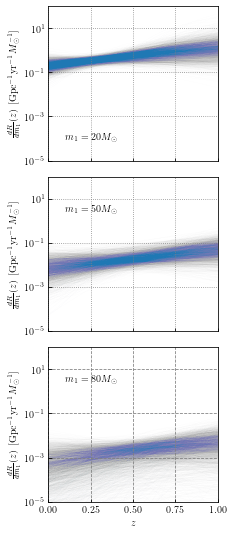

In [17]:
z_grid = np.linspace(0,1,500)

cm = 1/2.54
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8.5*cm, 3*6.375*cm), sharex=True)
ax1.set_rasterization_zorder(2)
ax2.set_rasterization_zorder(2)
ax3.set_rasterization_zorder(2)

R(20, samps, ax1)
R(50, samps, ax2)
R(80, samps, ax3)

ax3.set_xlim(0,1)
ax3.set_xlabel(r"$z$", fontsize=10)
ax3.tick_params(axis='x', labelsize=10)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.tight_layout()
plt.savefig("R(z)_one_plot.pdf", dpi=500, bbox_inches="tight")
plt.show()